### Set Up
Before running all codes at once, please make sure all directory settings in this code match with your environment. You can ctr+f "directory" to find all directory setting that you need to change

In [1]:
import pandas as pd
import numpy as np
import random
import psutil
import time 
import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from torch_geometric.data import Data

import networkx as nx
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Input Data

In [2]:
# Load the datasets
hr_df = pd.read_csv("/notebooks/hr_train.csv") # change the directory if needed
lr_df = pd.read_csv("/notebooks/lr_train.csv")

# Convert to numpy arrays
hr_data = hr_df.values
lr_data = lr_df.values

# Data Preprocessing

### Data Distirbution Visualization

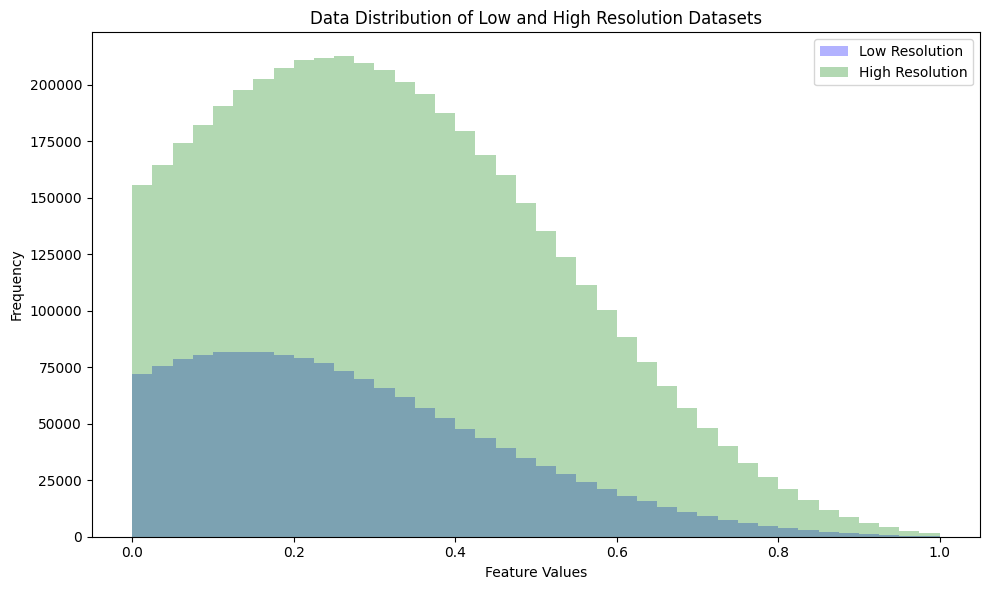

In [3]:
# Overlayed histograms for both datasets
plt.figure(figsize=(10, 6))

# Flatten the data to 1D for histogram plotting of non zero values
lr_flat = np.ravel(lr_data[lr_data != 0])
hr_flat = np.ravel(hr_data[hr_data != 0])

# Calculate the number of bins for the histogram
bins = np.histogram(np.hstack((lr_flat, hr_flat)), bins=40)[1] # get the bin edges

plt.hist(lr_flat, bins=bins, color='blue', alpha=0.3, label='Low Resolution', density=False)
plt.hist(hr_flat, bins=bins, color='green', alpha=0.3, label='High Resolution', density=False)

plt.title('Data Distribution of Low and High Resolution Datasets')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Vectorization & Antivectorization

In [4]:
class MatrixVectorizer:
    """
    A class for transforming between matrices and vector representations.
    
    This class provides methods to convert a symmetric matrix into a vector (vectorize)
    and to reconstruct the matrix from its vector form (anti_vectorize), focusing on 
    vertical (column-based) traversal and handling of elements.
    """

    def __init__(self):
        """
        Initializes the MatrixVectorizer instance.
        
        The constructor currently does not perform any actions but is included for 
        potential future extensions where initialization parameters might be required.
        """
        pass

    @staticmethod
    def vectorize(matrix, include_diagonal=False):
        """
        Converts a matrix into a vector by vertically extracting elements.
        
        This method traverses the matrix column by column, collecting elements from the
        upper triangle, and optionally includes the diagonal elements immediately below
        the main diagonal based on the include_diagonal flag.
        
        Parameters:
        - matrix (numpy.ndarray): The matrix to be vectorized.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the vectorization.
          Defaults to False.
        
        Returns:
        - numpy.ndarray: The vectorized form of the matrix.
        """
        # Determine the size of the matrix based on its first dimension
        matrix_size = matrix.shape[0]

        # Initialize an empty list to accumulate vector elements
        vector_elements = []

        # Iterate over columns and then rows to collect the relevant elements
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:  
                    if row < col:
                        # Collect upper triangle elements
                        vector_elements.append(matrix[row, col])
                    elif include_diagonal and row == col + 1:
                        # Optionally include the diagonal elements immediately below the diagonal
                        vector_elements.append(matrix[row, col])

        return np.array(vector_elements)

    @staticmethod
    def anti_vectorize(vector, matrix_size, include_diagonal=False):
        """
        Reconstructs a matrix from its vector form, filling it vertically.
        
        The method fills the matrix by reflecting vector elements into the upper triangle
        and optionally including the diagonal elements based on the include_diagonal flag.
        
        Parameters:
        - vector (numpy.ndarray): The vector to be transformed into a matrix.
        - matrix_size (int): The size of the square matrix to be reconstructed.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the reconstruction.
          Defaults to False.
        
        Returns:
        - numpy.ndarray: The reconstructed square matrix.
        """
        # Initialize a square matrix of zeros with the specified size
        matrix = np.zeros((matrix_size, matrix_size))

        # Index to keep track of the current position in the vector
        vector_idx = 0

        # Fill the matrix by iterating over columns and then rows
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:  
                    if row < col:
                        # Reflect vector elements into the upper triangle and its mirror in the lower triangle
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1
                    elif include_diagonal and row == col + 1:
                        # Optionally fill the diagonal elements after completing each column
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1

        return matrix

In [5]:
def load_data_as_graphs(df, matrix_size):
    graphs = []
    for index, row in df.iterrows():
        vector = row.values
        adjacency_matrix = MatrixVectorizer.anti_vectorize(vector, matrix_size)
        graph = Data(adjacency_matrix=np.array(adjacency_matrix))
        graphs.append(graph)
    return graphs

def get_matrix_size(num_features):
    return int(np.sqrt(num_features * 2)) + 1

### Split Data for Training, Testing, and Validation

In [6]:
# Determine the matrix size for low-resolution and high-resolution data
lr_matrix_size = get_matrix_size(lr_df.shape[1])
hr_matrix_size = get_matrix_size(hr_df.shape[1])

# Convert the dataframe to graph objects
lr_graphs = load_data_as_graphs(lr_df, lr_matrix_size)
hr_graphs = load_data_as_graphs(hr_df, hr_matrix_size)

# Split the data into training and test sets
lr_train, lr_test, hr_train, hr_test = train_test_split(
    lr_graphs, hr_graphs, test_size=0.2, random_state=42
)

In [7]:
print("LR Train Set samples: ",len(lr_train))
print("LR Test Set samples: ",len(lr_test))

print("HR Train Set samples: ",len(hr_train))
print("HR Test Set samples: ",len(lr_test))

LR Train Set samples:  133
LR Test Set samples:  34
HR Train Set samples:  133
HR Test Set samples:  34


In [8]:
# convert list to tensor
lr_train_array = np.random.normal(0.5, 1,(len(lr_train), 160, 160))
hr_train_array = np.random.normal(0.5, 1,(len(hr_train), 268, 268))
lr_test_array = np.random.normal(0.5, 1,(len(lr_test), 160, 160))
hr_test_array = np.random.normal(0.5, 1,(len(hr_test), 268, 268))
i = 0

for lr, hr in zip(lr_train, hr_train):
    lr_train_array[i] = lr.adjacency_matrix
    hr_train_array[i] = hr.adjacency_matrix
    i +=1

j = 0
for lr, hr in zip(lr_test, hr_test):
    lr_test_array[j] = lr.adjacency_matrix
    hr_test_array[j] = hr.adjacency_matrix
    i +=1

print(lr_train_array.shape)
print(lr_test_array.shape)

(133, 160, 160)
(34, 160, 160)


# Model Implementation

## LL-GSR

### Model Definition

In [9]:
## Helper Functions
# Initialize a weight matrix
def weight_variable_glorot(output_dim):
    input_dim = output_dim
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = np.random.uniform(-init_range, init_range,(input_dim, output_dim))
    return initial

# Normalize the adjacency matrix of the graph
def normalize_adj_torch(mx):
    rowsum = mx.sum(1)
    r_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
    r_inv_sqrt[torch.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = torch.diag(r_inv_sqrt)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    mx = torch.transpose(mx, 0, 1)
    mx = torch.matmul(mx,  r_mat_inv_sqrt)
    return mx

In [10]:
#GAT
class GAT(nn.Module):
    """ 
    This layer applies an attention mechanism in the graph convolution process,
    allowing the model to focus on different parts of the neighborhood
    of each node.
    """
    def __init__(self, in_features, out_features, activation=F.relu):
        """        
        Parameters:
            in_features (int): The number of features of each input node.
            out_features (int): The number of features for each output node.
            activation (callable, optional): The activation function to use. Default is F.relu.
        """

        super(GAT, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.phi = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.activation = activation
        self.reset_parameters()
        self.drop = nn.Dropout(p=0.5)
 
    def reset_parameters(self):
        """
        Initializes or resets the parameters of the layer.
        """

        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
 
        stdv = 1. / np.sqrt(self.phi.size(1))
        self.phi.data.uniform_(-stdv, stdv)
 
    def forward(self,adj,input):
        """
        Forward pass of the GAT layer.
 
        Parameters:
        input (Tensor): The input features of the nodes.
        adj (Tensor): The adjacency matrix of the graph.
 
        Returns:
        Tensor: The output features of the nodes after applying the GAT layer.
        """
        
        input = self.drop(input)
        h = torch.mm(input, self.weight) + self.bias 
 
        N = input.size(0) 
        h_expand = h.unsqueeze(1).expand(N, N, -1)
        h_t_expand = h.unsqueeze(0).expand(N, N, -1)
        
        concat_features = torch.cat([h_expand, h_t_expand], dim=-1)
        
        S = torch.matmul(concat_features, self.phi).squeeze(-1)
 
        mask = (adj.to(device) + torch.eye(adj.size(0),device=device)).bool()
        S_masked = torch.where(mask, S, torch.tensor(-9e15, dtype=S.dtype).to(device))
        attention_weights = F.softmax(S_masked, dim=1)
        h = torch.matmul(attention_weights, h)
        return self.activation(h) if self.activation else h
    
class GraphUnpool(nn.Module):
    """    
    This layer "unpools" a graph to a larger graph based on the provided indices.
    """
    def __init__(self):
        super(GraphUnpool, self).__init__()

    def forward(self, A, X, idx):
        """        
        Parameters:
            A (Tensor): The adjacency matrix of the smaller graph.
            X (Tensor): The node features of the smaller graph.
            idx (Tensor): The indices of nodes in the original graph.
        
        Returns:
            Tensor, Tensor: The adjacency matrix and node features of the unpooled graph.
        """

        new_X = torch.zeros([A.shape[0], X.shape[1]]).to(device)
        new_X[idx] = X
        return A, new_X

    
class GraphPool(nn.Module):
    """    
    This layer pools a graph based on the learned scores for each node, reducing the number of nodes in the graph.
    """

    def __init__(self, k, in_dim):
        super(GraphPool, self).__init__()
        self.k = k
        self.proj = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, A, X):
        scores = self.proj(X)
        scores = torch.squeeze(scores)
        scores = self.sigmoid(scores/100)
        num_nodes = A.shape[0]
        values, idx = torch.topk(scores, int(self.k*num_nodes))
        new_X = X[idx, :]
        values = torch.unsqueeze(values, -1)
        new_X = torch.mul(new_X, values)
        A = A[idx, :]
        A = A[:, idx]
        return A, new_X, idx


class GraphUnet(nn.Module):
    """    
    This model combines the GAT layers with graph pooling and unpooling layers to create an architecture for graphs.
    """

    def __init__(self, ks, in_dim, out_dim, dim=268):
        super(GraphUnet, self).__init__()
        self.ks = ks
        self.start_gat = GAT(in_dim, dim).to(device)
        self.bottom_gat = GAT(dim, dim).to(device)
        self.end_gat = GAT(2*dim, out_dim).to(device)
        self.down_gats = []
        self.up_gats = []
        self.pools = []
        self.unpools = []
        self.l_n = len(ks)
        for i in range(self.l_n):
            self.down_gats.append(GAT(dim, dim).to(device))
            self.up_gats.append(GAT(dim, dim).to(device))
            self.pools.append(GraphPool(ks[i], dim).to(device))
            self.unpools.append(GraphUnpool().to(device))

    def forward(self, A, X):
        adj_ms = []
        indices_list = []
        down_outs = []
        X = self.start_gat(A, X)
        start_gat_outs = X
        org_X = X
        for i in range(self.l_n):
            X = self.down_gats[i](A, X)
            adj_ms.append(A)
            down_outs.append(X)
            A, X, idx = self.pools[i](A, X)
            indices_list.append(idx)
        
        X = self.bottom_gat(A, X)
        
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1
            A, idx = adj_ms[up_idx], indices_list[up_idx]
            A, X = self.unpools[i](A, X, idx)
            X = self.up_gats[i](A, X)
            X = X.add(down_outs[up_idx])
        X = torch.cat([X, org_X], 1)
        X = self.end_gat(A, X)
        
        return X, start_gat_outs


class GSRLayer(nn.Module):
    """    
    This layer aims to learn a high-resolution representation of a graph from its low-resolution counterpart.
    """

    def __init__(self,hr_dim):
        super(GSRLayer, self).__init__()
        
        self.hr_dim = hr_dim
        self.weights = torch.from_numpy(weight_variable_glorot(hr_dim)).type(torch.FloatTensor).to(device)
        self.weights = torch.nn.Parameter(data=self.weights, requires_grad = True).to(device)

    def forward(self,A,X):
        lr = A
        lr_dim = lr.shape[0]
        hr_dim = self.hr_dim
        f = X
        eig_val_lr, U_lr = torch.linalg.eigh(lr, UPLO='U')
        eye_mat = torch.eye(lr_dim).type(torch.FloatTensor).to(device)
        s_d = torch.cat((eye_mat, torch.ones(hr_dim - lr_dim, lr_dim).to(device)), dim=0)
        a = torch.matmul(self.weights,s_d)
        b = torch.matmul(a ,torch.t(U_lr))
        f_d = torch.matmul(b ,f)
        f_d = torch.abs(f_d)
        self.f_d = f_d.fill_diagonal_(1)
        adj = normalize_adj_torch(self.f_d)
        X = torch.mm(adj, adj.t())
        X = (X + X.t())/2
        idx = torch.eye(268, dtype=bool)
        X[idx]=1
        return adj, torch.abs(X)
    

class GraphConvolution(nn.Module):
    """    
    This layer applies a graph convolution operation on the graph nodes.
    """

    def __init__(self, in_features, out_features, dropout=0.5, act=F.relu):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.act = act
        self.weight = torch.nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        input = F.dropout(input, self.dropout, self.training)
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        output = self.act(output)
        return output
    
    
class GSRNet(nn.Module):
    """
    This network combines graph convolutional layers with a Graph U-Net structure and a super-resolution layer to enhance the resolution of graph data.
    """
    
    def __init__(self,ks,args):
        super(GSRNet, self).__init__()

        self.lr_dim = args.lr_dim
        self.hr_dim = args.hr_dim
        self.hidden_dim = args.hidden_dim
        self.layer = GSRLayer(self.hr_dim).to(device)
        self.net = GraphUnet(ks, self.lr_dim, self.hr_dim).to(device)
        self.gc1 = GraphConvolution(self.hr_dim, self.hidden_dim, 0, act=F.relu).to(device)
        self.gc2 = GraphConvolution(self.hidden_dim, self.hr_dim, 0, act=F.relu).to(device)

    def forward(self,lr):
        I = torch.eye(self.lr_dim).type(torch.FloatTensor).to(device)
        A = normalize_adj_torch(lr).type(torch.FloatTensor).to(device)

        self.net_outs, self.start_gat_outs = self.net(A, I)
        self.outputs, self.Z = self.layer(A, self.net_outs)

        self.hidden1 = self.gc1(self.Z, self.outputs)
        self.hidden2 = self.gc2(self.hidden1, self.outputs)

        z = self.hidden2
        z = (z + z.t())/2
        idx = torch.eye(self.hr_dim, dtype=bool) 
        z[idx]=1

        return torch.abs(z), self.net_outs, self.start_gat_outs, self.outputs

### Model Training

In [11]:
# Set a fixed random seed for reproducibility across multiple libraries
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 2)  # Convert to MB

CUDA is available. Using GPU.


In [12]:
criterion = nn.MSELoss()
criterion.to(device)

def create_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

def train(model, optimizer, subjects_adj, subjects_labels, args):
    """
    Trains a graph super-resolution network on a dataset of low-resolution and high-resolution adjacency matrices.
    
    Parameters:
        model: The graph super-resolution network to be trained.
        optimizer: The optimizer used to update the model's weights.
        subjects_adj: A list of low-resolution adjacency matrices (the dataset).
        subjects_labels: A list of high-resolution adjacency matrices (the labels).
        args: A namespace or an object containing training parameters such as epochs and batch_size.
    """
    
    # Initialize training variables
    i = 0
    all_epochs_loss = []
    no_epochs = args.epochs
    memory_usage_list = []
    batch_size = args.batch_size  # Assuming batch_size is added to Args class

    # Record start time
    start_time = time.time()

    # Training loop
    for epoch in range(no_epochs):
        epoch_loss = []
        epoch_error = []

        # Create batches
        lr_batches = list(create_batches(subjects_adj, batch_size))
        hr_batches = list(create_batches(subjects_labels, batch_size))
        
        for lr_batch, hr_batch in zip(lr_batches, hr_batches):
            model.train()
            optimizer.zero_grad()   

            # Initialize batch_loss as a zero tensor that requires grad
            batch_loss = torch.tensor(0., device=device, requires_grad=True)
            batch_error = 0

            # Process each (lr, hr) pair in the batch
            for lr, hr in zip(lr_batch, hr_batch):
                lr_tensor = torch.from_numpy(lr).type(torch.FloatTensor).to(device)
                hr_tensor = torch.from_numpy(hr).type(torch.FloatTensor).to(device)  
                model_outputs, net_outs, start_gat_outs, layer_outs = model(lr_tensor)
                
                hr_p = hr_tensor.cpu()
                eig_val_hr, U_hr = torch.linalg.eigh(hr_p.to(device), UPLO='U')

                # loss function
                loss = args.lmbda1 * criterion(net_outs, start_gat_outs) + criterion(model.layer.weights,U_hr) + args.lmbda2*criterion(model_outputs, hr_tensor) 
                error = criterion(model_outputs, hr_tensor)

                if batch_loss.grad_fn is not None:
                    batch_loss = batch_loss + loss
                else:
                    batch_loss = loss.detach().requires_grad_()
 
                batch_error += error.item()
            
            loss.backward()
            optimizer.step()

            epoch_loss.append(batch_loss.item())
            epoch_error.append(batch_error / len(lr_batch))  # error
      
        i+=1
        print("Epoch: ",i, "Loss: ", np.mean(epoch_loss), "Error: ", np.mean(epoch_error)*100,"%")
        all_epochs_loss.append(np.mean(epoch_loss))

        # calculate memory usage in MB
        memory_usage = get_memory_usage()
        memory_usage_list.append(memory_usage)
        
    end_time = time.time()
    total_training_time = end_time - start_time

    torch.save(model, args.model_path)
    
    # plot loss 
    plt.plot(all_epochs_loss)
    plt.title('GSR-UNet with self reconstruction: Loss')
    plt.show(block=False)
    # Record end time
   
    print(f"Total Training Time: {total_training_time:.2f} seconds")
    print(f"\n Avergae Memory Usage: {np.mean(memory_usage)} MB")

In [13]:
class Args:
    """
    A class to store the configuration settings for the training process.
    
    Attributes:
        epochs (int): Number of epochs to train the model.
        lr (float): Learning rate for the optimizer.
        splits (int): Number of splits for cross-validation.
        lmbda1 (int): Coefficient for the first part of the composite loss function.
        lmbda2 (int): Coefficient for the second part of the composite loss function.
        lr_dim (int): Dimension of the low-resolution graphs.
        hr_dim (int): Dimension of the high-resolution graphs.
        hidden_dim (int): Dimension of the hidden layers in the graph neural network.
        batch_size (int): Number of samples per batch.
        model_path (str): File path to save the trained model.
    """

    def __init__(self):
        self.epochs = 200
        self.lr = 0.0001
        self.splits = 5
        self.lmbda1 = 16
        self.lmbda2 = 2
        self.lr_dim = 160
        self.hr_dim = 268
        self.hidden_dim = 320
        self.batch_size = 2
        self.model_path = "/notebooks/gsr_model.pt" #change directory if needed

args = Args()

# Define the pooling ratios for the Graph U-Net architecture
ks = [0.9, 0.7, 0.6, 0.5]

model = GSRNet(ks, args) 
optimizer = optim.AdamW(model.parameters(), lr=args.lr)

def count_parameters(model_check):
    return sum(p.numel() for p in model_check.parameters() if p.requires_grad)
print(model)

model_params = count_parameters(model)
print(f"Model Parameters: {model_params}")

GSRNet(
  (layer): GSRLayer()
  (net): GraphUnet(
    (start_gat): GAT(
      (drop): Dropout(p=0.5, inplace=False)
    )
    (bottom_gat): GAT(
      (drop): Dropout(p=0.5, inplace=False)
    )
    (end_gat): GAT(
      (drop): Dropout(p=0.5, inplace=False)
    )
  )
  (gc1): GraphConvolution()
  (gc2): GraphConvolution()
)
Model Parameters: 504108


# Evaluation

### Testing

In [14]:
def test(model, test_adj, test_labels, args):
    """    
    Parameters:
        model: The trained GSRNet model.
        test_adj: Numpy array of adjacency matrices for the test dataset (low-resolution).
        test_labels: Numpy array of ground truth adjacency matrices for the test dataset (high-resolution).
        args: Configuration settings that include model and dataset specifications.
    
    Returns:
        pred_matrices: Predicted high-resolution adjacency matrices for the test dataset.
        gt_matrices: Ground truth high-resolution adjacency matrices for the test dataset.
    """

    test_error = []
    preds_list=[]
    g_t = []
    num_test_samples = test_adj.shape[0]
    num_roi = args.hr_dim
    pred_matrices = torch.randn(num_test_samples, num_roi, num_roi).numpy()
    gt_matrices = torch.randn(num_test_samples, num_roi, num_roi).numpy()

    i = 0
    
    # Iterate over each pair of low-resolution input and high-resolution ground truth
    for lr, hr in zip(test_adj,test_labels):

        all_zeros_lr = not np.any(lr)
        all_zeros_hr = not np.any(hr)

        if all_zeros_lr == False and all_zeros_hr==False: #choose representative subject
            lr = torch.from_numpy(lr).type(torch.FloatTensor).to(device)
            np.fill_diagonal(hr,1)
            hr = torch.from_numpy(hr).type(torch.FloatTensor).to(device)
            preds,a,b,c = model(lr)

            preds_list.append(preds.flatten().detach().cpu().clone().numpy())
            error = criterion(preds, hr)
            g_t.append(hr.flatten())
            test_error.append(error.item())

            pred_matrices[i] = preds.detach().cpu().clone().numpy()
            gt_matrices[i]   = hr.detach().cpu().clone().numpy()
            i += 1
            
    print ("Test error MSE: ", np.mean(test_error))
    return pred_matrices, gt_matrices

### 3-Fold Cross Validation

In [15]:
def process_sample(pred_matrix, gt_matrix):
    """
    Calculates the mean absolute error (MAE) between centrality measures of predicted and ground truth graphs.
    
    Parameters:
        pred_matrix (numpy.ndarray): The predicted adjacency matrix of the graph.
        gt_matrix (numpy.ndarray): The ground truth adjacency matrix of the graph.
    
    Returns:
        tuple: Contains MAE for betweenness centrality, eigenvector centrality, and PageRank.
    """

    pred_graph = nx.from_numpy_array(pred_matrix)
    gt_graph = nx.from_numpy_array(gt_matrix)
    
    # Calculate centrality measures for both predicted and ground truth graphs
    pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
    pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
    pred_pc = nx.pagerank(pred_graph, weight="weight")

    gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
    gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
    gt_pc = nx.pagerank(gt_graph, weight="weight")

    # Convert centrality measures to lists for comparison
    pred_bc_values = list(pred_bc.values())
    pred_ec_values = list(pred_ec.values())
    pred_pc_values = list(pred_pc.values())

    gt_bc_values = list(gt_bc.values())
    gt_ec_values = list(gt_ec.values())
    gt_pc_values = list(gt_pc.values())

    # Calculate MAE for each centrality measure
    mae_bc = mean_absolute_error(pred_bc_values, gt_bc_values)
    mae_ec = mean_absolute_error(pred_ec_values, gt_ec_values)
    mae_pc = mean_absolute_error(pred_pc_values, gt_pc_values)
    
    return mae_bc, mae_ec, mae_pc

def evaluation_parallel(pred_matrices, gt_matrices, num_test_samples, fold=1):
    """
    Evaluates predicted graphs in parallel, calculating various error metrics and correlations.
    
    Parameters:
        pred_matrices (numpy.ndarray): Array of predicted adjacency matrices.
        gt_matrices (numpy.ndarray): Array of ground truth adjacency matrices.
        num_test_samples (int): Number of test samples to evaluate.
        fold (int): Current fold of cross-validation (for tracking purposes).
    
    Returns:
        tuple: Contains overall MAE, Pearson correlation coefficient, Jensen-Shannon distance,
               and average MAE for betweenness centrality, eigenvector centrality, and PageRank.
    """

    # Initialize lists to store MAEs for centrality measures
    mae_bc_list = []
    mae_ec_list = []
    mae_pc_list = []
    
    # Evaluate each sample in parallel using ProcessPoolExecutor
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_sample, pred_matrices[i], gt_matrices[i]) for i in range(num_test_samples)]
        for future in tqdm(as_completed(futures), total=num_test_samples, desc="Evaluating"):
            mae_bc, mae_ec, mae_pc = future.result()
            mae_bc_list.append(mae_bc)
            mae_ec_list.append(mae_ec)
            mae_pc_list.append(mae_pc)

    # Prepare data for vectorized operations
    pred_1d_list = []
    gt_1d_list = []

    # Vectorize matrices and accumulate for all samples
    for i in range(num_test_samples):
        pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(gt_matrices[i]))
        
    # Compute average MAEs
    avg_mae_bc = np.mean(mae_bc_list) 
    avg_mae_ec = np.mean(mae_ec_list)
    avg_mae_pc = np.mean(mae_pc_list)
        
    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Scalling Vectorization
    scaler1 = MinMaxScaler()
    scaler2 = MinMaxScaler()
    pred_1d_norm = scaler1.fit_transform(pred_1d.reshape(-1, 1))
    gt_1d_norm = scaler2.fit_transform(gt_1d.reshape(-1, 1))
    pred_1d_norm = pred_1d_norm.reshape(-1)
    gt_1d_norm = gt_1d_norm.reshape(-1)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d_norm, gt_1d_norm)
    
    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc

In [16]:
def cv_submission(filepath, data_array, fold=1, vector_dim=35778):
    n_samples = data_array.shape[0]
    results_array = np.zeros((n_samples, vector_dim))
    i = 0

    # Iterate over each predicted matrix, vectorize it, and store it in the results array
    for preds in data_array:
        vectorized_pred = MatrixVectorizer.vectorize(preds) 
        results_array[i, :] = vectorized_pred
        i += 1
    
    melted_result = results_array.flatten()
    ids = np.arange(1, melted_result.shape[0]+1)
    df = pd.DataFrame({
        "ID": ids,
        "Predicted": melted_result
    })

    print(df.head())
    df.to_csv(filepath, index=False)
    print("the results are saved")
    return 

Fold 1, train split: 111 samples, test split: 56 samples
Epoch:  1 Loss:  0.7315358016639948 Error:  36.38665268663317 %
Epoch:  2 Loss:  0.6781386980520827 Error:  33.710858661548365 %
Epoch:  3 Loss:  0.630081057548523 Error:  31.2949310489265 %
Epoch:  4 Loss:  0.5976495287780251 Error:  29.659155244007707 %
Epoch:  5 Loss:  0.5799111139827541 Error:  28.760646423324943 %
Epoch:  6 Loss:  0.5720337931332844 Error:  28.360648543041734 %
Epoch:  7 Loss:  0.569035893040044 Error:  28.20759195767875 %
Epoch:  8 Loss:  0.5678873396079455 Error:  28.15176749136299 %
Epoch:  9 Loss:  0.5673254717673574 Error:  28.126925472835346 %
Epoch:  10 Loss:  0.5668836538014668 Error:  28.110040245311602 %
Epoch:  11 Loss:  0.5665026957701359 Error:  28.096474896717282 %
Epoch:  12 Loss:  0.5661005113007767 Error:  28.0814802340631 %
Epoch:  13 Loss:  0.5657170158145683 Error:  28.06766097367342 %
Epoch:  14 Loss:  0.5653432863099235 Error:  28.054191807418 %
Epoch:  15 Loss:  0.5649697301643235 Erro

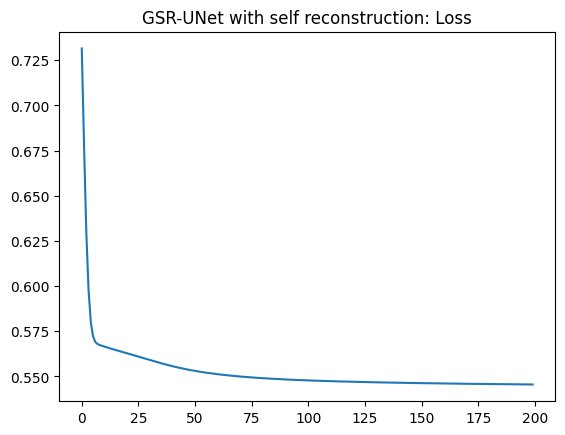

Total Training Time: 840.81 seconds

 Avergae Memory Usage: 2724.26953125 MB
Test error MSE:  0.18155464633101864


Evaluating: 100%|██████████| 56/56 [09:46<00:00, 10.47s/it] 


   ID  Predicted
0   1   0.525118
1   2   0.616993
2   3   0.694713
3   4   0.483864
4   5   0.617156
the results are saved


Fold 2, train split: 111 samples, test split: 56 samples
Epoch:  1 Loss:  0.4825615602146302 Error:  23.80917289826487 %
Epoch:  2 Loss:  0.48208402722541777 Error:  23.789287985502078 %
Epoch:  3 Loss:  0.48175933424915585 Error:  23.776248844140873 %
Epoch:  4 Loss:  0.48155421178255764 Error:  23.76900300150737 %
Epoch:  5 Loss:  0.4814056944368141 Error:  23.76434079072039 %
Epoch:  6 Loss:  0.4812867609517915 Error:  23.760919751865522 %
Epoch:  7 Loss:  0.4811846164188215 Error:  23.7581318177815 %
Epoch:  8 Loss:  0.4810929929039308 Error:  23.755699587387166 %
Epoch:  9 Loss:  0.4810085959200348 Error:  23.753488097073777 %
Epoch:  10 Loss:  0.4809296548898731 Error:  23.751435636742308 %
Epoch:  11 Loss:  0.48085489084145855 Error:  23.74949659653274 %
Epoch:  12 Loss:  0.4807837549597025 Error:  23.74766088489975 %
Epoch:  13 Loss:  0.4807156136791621 

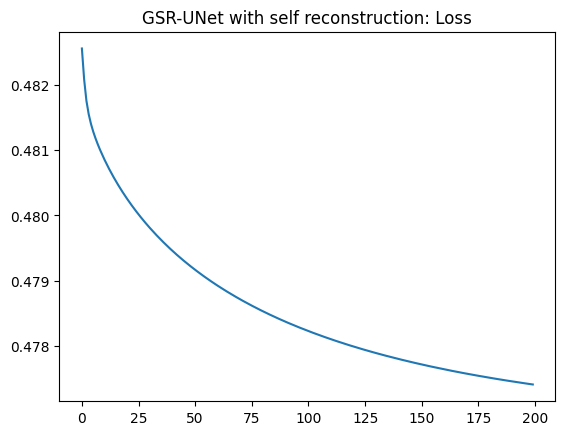

Total Training Time: 843.44 seconds

 Avergae Memory Usage: 2807.51953125 MB
Test error MSE:  0.25155992107465863


Evaluating: 100%|██████████| 56/56 [09:58<00:00, 10.69s/it] 


   ID  Predicted
0   1   0.563565
1   2   0.502934
2   3   0.653427
3   4   0.555391
4   5   0.644315
the results are saved


Fold 3, train split: 112 samples, test split: 55 samples
Epoch:  1 Loss:  0.44553767264421495 Error:  21.99431416645114 %
Epoch:  2 Loss:  0.44495884901178734 Error:  21.978136927022465 %
Epoch:  3 Loss:  0.44461749706949505 Error:  21.96932958073116 %
Epoch:  4 Loss:  0.4444025106994169 Error:  21.96420538738104 %
Epoch:  5 Loss:  0.4442461313280676 Error:  21.96057718746098 %
Epoch:  6 Loss:  0.44412023374544723 Error:  21.95765272481367 %
Epoch:  7 Loss:  0.4440117987937161 Error:  21.955099648662976 %
Epoch:  8 Loss:  0.44391444717933026 Error:  21.95277346264837 %
Epoch:  9 Loss:  0.4438247978022056 Error:  21.95060524224703 %
Epoch:  10 Loss:  0.44374090107157826 Error:  21.948556783276477 %
Epoch:  11 Loss:  0.443661748431623 Error:  21.946614747866988 %
Epoch:  12 Loss:  0.44358658438016263 Error:  21.944767772220075 %
Epoch:  13 Loss:  0.443515009313289

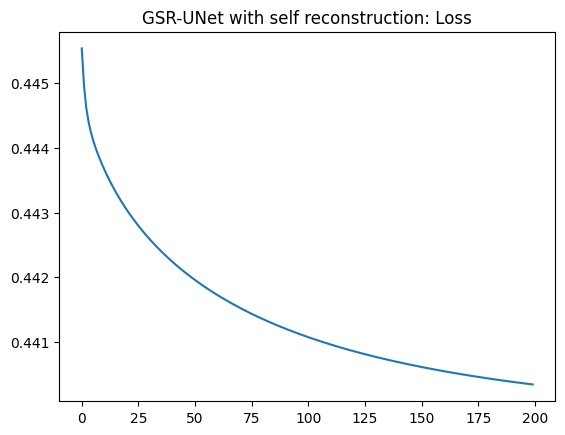

Total Training Time: 857.08 seconds

 Avergae Memory Usage: 2838.8828125 MB
Test error MSE:  0.2737969375469468


Evaluating: 100%|██████████| 55/55 [10:53<00:00, 11.88s/it] 


   ID  Predicted
0   1   0.573943
1   2   0.534015
2   3   0.629852
3   4   0.619568
4   5   0.637498
the results are saved



 Evaluation Metrics of Fold:  1
MAE:  0.2559724
PCC:  0.24589405296385314
Jensen-Shannon Distance:  0.11792627953238936
Average MAE betweenness centrality: 0.08597598913613302
Average MAE eigenvector centrality: 0.014004542866352726
Average MAE PageRank centrality: 0.0005686720121834737

 Evaluation Metrics of Fold:  2
MAE:  0.2984418
PCC:  0.2038479856939121
Jensen-Shannon Distance:  0.12963272339702794
Average MAE betweenness centrality: 0.12035491371363413
Average MAE eigenvector centrality: 0.013198978523465613
Average MAE PageRank centrality: 0.0005503115683366868

 Evaluation Metrics of Fold:  3
MAE:  0.3110256
PCC:  0.19069011418958104
Jensen-Shannon Distance:  0.13683877853245088
Average MAE betweenness centrality: 0.13045653921824515
Average MAE eigenvector centrality: 0.0126007986214973
Average MAE PageRank centrality: 0.0005257237215319604

 Evaluati

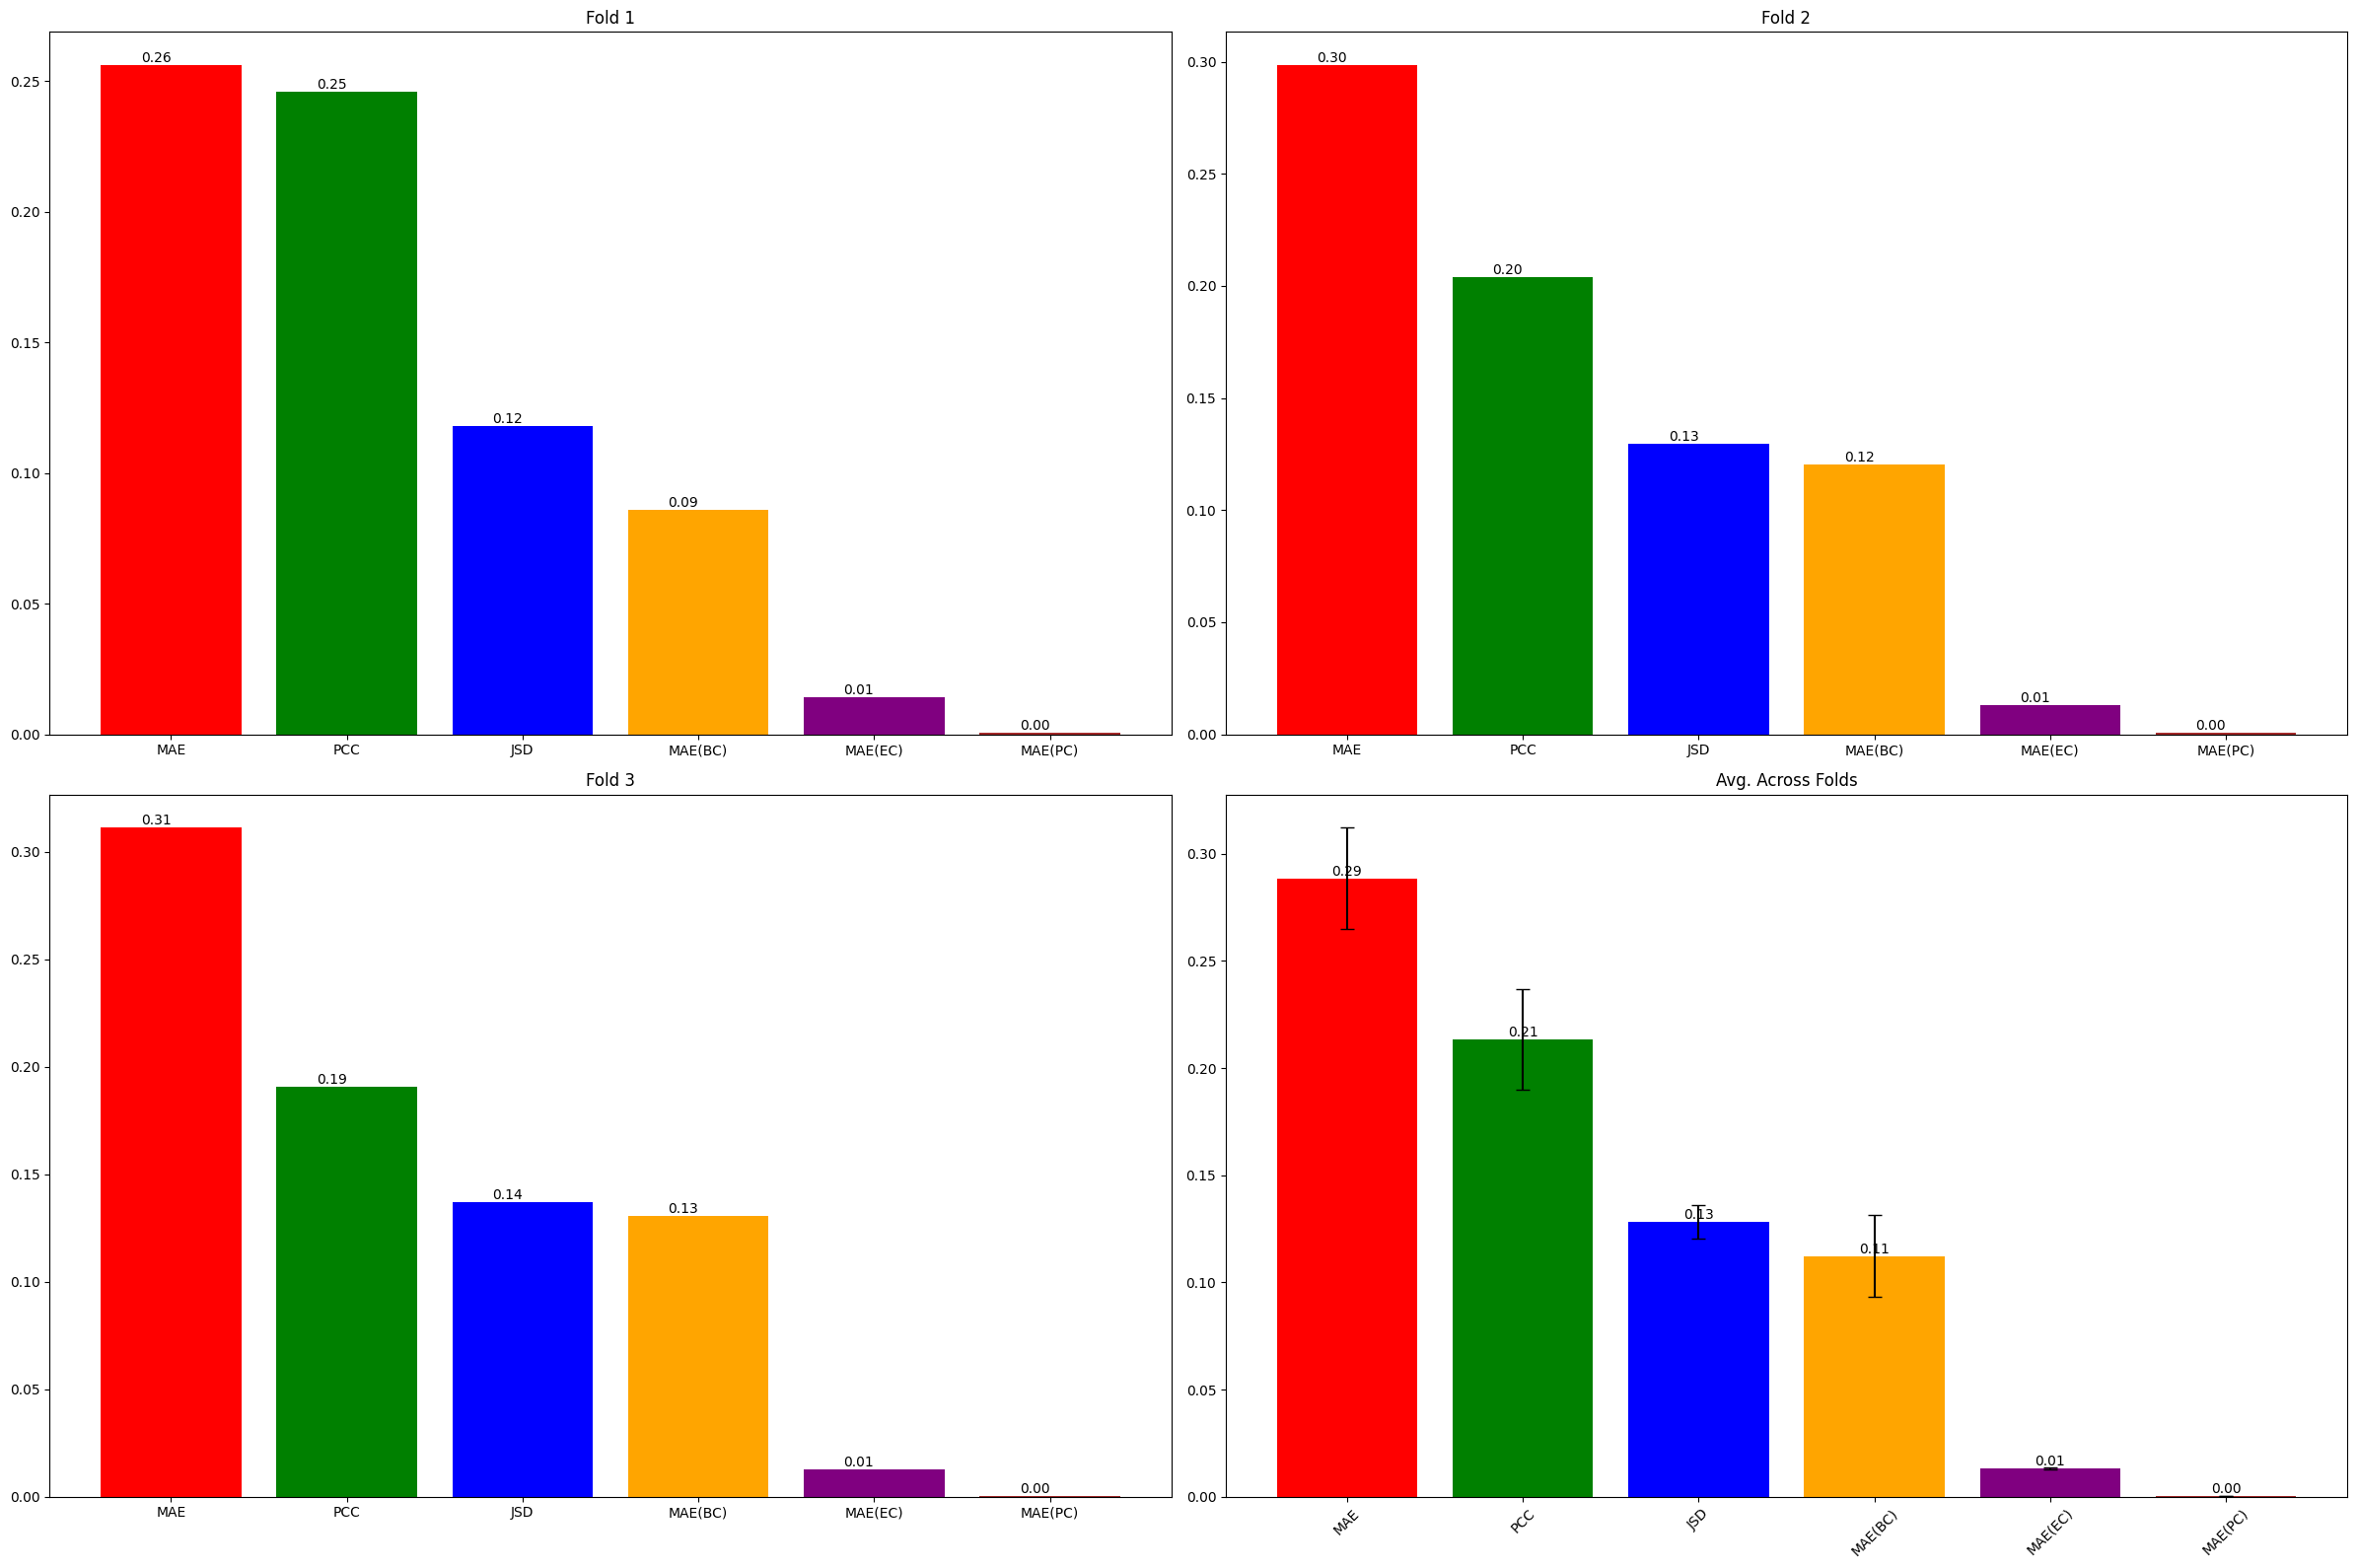

In [17]:
cv = KFold(n_splits=3, random_state=42, shuffle=True)
fold = 0
model.to(device)
cv_filename = f"predictions_fold_{fold}.csv"
cv_filepath = "/notebooks/" + cv_filename # change directory if needed

# Combine all training data for 3f-CV
lr_training = np.concatenate((lr_train_array, lr_test_array), axis=0)
hr_training = np.concatenate((hr_train_array, hr_test_array), axis=0)

# Initialize lists to store evaluation metrics across all folds
mae_list = []
pcc_list = []
js_dis_list = []
avg_mae_bc_list = []
avg_mae_ec_list = []
avg_mae_pc_list = []

# Loop through each fold in the cross-validation
for train_index, test_index in cv.split(lr_training):
    fold +=1
    len_train = len(train_index)
    len_test = len(test_index)
    print(f"Fold {fold}, train split: {len_train} samples, test split: {len_test} samples")

    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = lr_training[
        train_index], lr_training[test_index], hr_training[train_index], hr_training[test_index]
    
    train(model, optimizer, subjects_adj, subjects_ground_truth, args)
    prediction, ground_truth = test(model, test_adj, test_ground_truth, args)
    mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc = evaluation_parallel(prediction, ground_truth, len_test, fold)

    # Store the evaluation metrics for this fold
    mae_list.append(mae)
    pcc_list.append(pcc)
    js_dis_list.append(js_dis)
    avg_mae_bc_list.append(avg_mae_bc)
    avg_mae_ec_list.append(avg_mae_ec)
    avg_mae_pc_list.append(avg_mae_pc)

    cv_submission(cv_filepath, prediction, fold)
    print("\n")

# Calculate the mean and standard deviation of the evaluation metrics across all folds
mae_fm = np.mean(mae_list)
pcc_fm = np.mean(pcc_list)
js_dis_fm = np.mean(js_dis_list)
avg_mae_bc_fm = np.mean(avg_mae_bc_list)
avg_mae_ec_fm = np.mean(avg_mae_ec_list)
avg_mae_pc_fm = np.mean(avg_mae_pc_list)

mae_fs = np.std(mae_list)
pcc_fs = np.std(pcc_list)
js_dis_fs = np.std(js_dis_list)
avg_mae_bc_fs = np.std(avg_mae_bc_list)
avg_mae_ec_fs = np.std(avg_mae_ec_list)
avg_mae_pc_fs = np.std(avg_mae_pc_list)


### Plot the graphs
plt.figure(figsize=(24, 16))
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
 
# Loop through each fold to plot its evaluation metrics
for i in range(3):
    print("\n Evaluation Metrics of Fold: ", i+1)
    print("MAE: ", mae_list[i])
    print("PCC: ", pcc_list[i])
    print("Jensen-Shannon Distance: ", js_dis_list[i])
    print("Average MAE betweenness centrality:", avg_mae_bc_list[i])
    print("Average MAE eigenvector centrality:", avg_mae_ec_list[i])
    print("Average MAE PageRank centrality:", avg_mae_pc_list[i])
    
    plt.subplot(2, 2, i+1) 
    bar = np.array([mae_list[i], pcc_list[i], js_dis_list[i], avg_mae_bc_list[i], avg_mae_ec_list[i], avg_mae_pc_list[i]])
    x = np.array(['MAE','PCC','JSD','MAE(BC)','MAE(EC)','MAE(PC)'])
    y = np.arange(len(bar))
    plt.bar(y,bar,color=colors)

    for a, b in zip(y,bar):
        plt.text(a,b,('%.2f'%b),verticalalignment='bottom',horizontalalignment='right')

    plt.xticks(y,x)
    plt.title(f'Fold {i+1}')

plt.subplot(2, 2, 4) 
means = [mae_fm, pcc_fm, js_dis_fm, avg_mae_bc_fm, avg_mae_ec_fm, avg_mae_pc_fm]
stds = [mae_fs, pcc_fs, js_dis_fs, avg_mae_bc_fs, avg_mae_ec_fs, avg_mae_pc_fs]
x = np.array(['MAE','PCC','JSD','MAE(BC)','MAE(EC)','MAE(PC)'])
plt.bar(x, means, yerr=stds, capsize=5, color=colors)

# Print average evaluation metrics for all folds
print("\n Evaluation Metrics of All Folds (Avg.): ")
print("MAE: ", mae_fm)
print("PCC: ", pcc_fm)
print("Jensen-Shannon Distance: ", js_dis_fm)
print("Average MAE betweenness centrality:", avg_mae_bc_fm)
print("Average MAE eigenvector centrality:", avg_mae_ec_fm)
print("Average MAE PageRank centrality:", avg_mae_pc_fm)

for x, y, std in zip(x, means, stds):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
    
plt.xticks(rotation=45)
plt.title('Avg. Across Folds')

plt.tight_layout()
plt.show()

Epoch:  1 Loss:  0.49043635997389046 Error:  24.328795267224667 %
Epoch:  2 Loss:  0.4903755280677052 Error:  24.334030220329407 %
Epoch:  3 Loss:  0.49039892807957675 Error:  24.3405697401613 %
Epoch:  4 Loss:  0.49035740222427104 Error:  24.341745504976384 %
Epoch:  5 Loss:  0.49029165666018215 Error:  24.34081987233921 %
Epoch:  6 Loss:  0.4902213371935345 Error:  24.339240801609343 %
Epoch:  7 Loss:  0.49015293181652114 Error:  24.337521767509834 %
Epoch:  8 Loss:  0.4900883340853311 Error:  24.335842694909797 %
Epoch:  9 Loss:  0.49002785169120344 Error:  24.334264383651316 %
Epoch:  10 Loss:  0.489971148116248 Error:  24.332794395186717 %
Epoch:  11 Loss:  0.489917782977933 Error:  24.331426822269954 %
Epoch:  12 Loss:  0.489867751264856 Error:  24.330172550287983 %
Epoch:  13 Loss:  0.4898204260195295 Error:  24.329007523400442 %
Epoch:  14 Loss:  0.48977574626249926 Error:  24.327934262830585 %
Epoch:  15 Loss:  0.48973321240572704 Error:  24.32693205552087 %
Epoch:  16 Loss:  

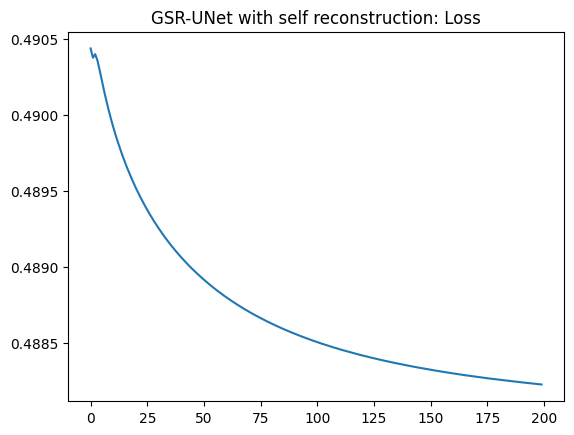

Total Training Time: 1278.43 seconds

 Avergae Memory Usage: 2880.48828125 MB


In [18]:
# Combine all training data for 3f-CV
train(model, optimizer, lr_training, hr_training, args)

# Visualization

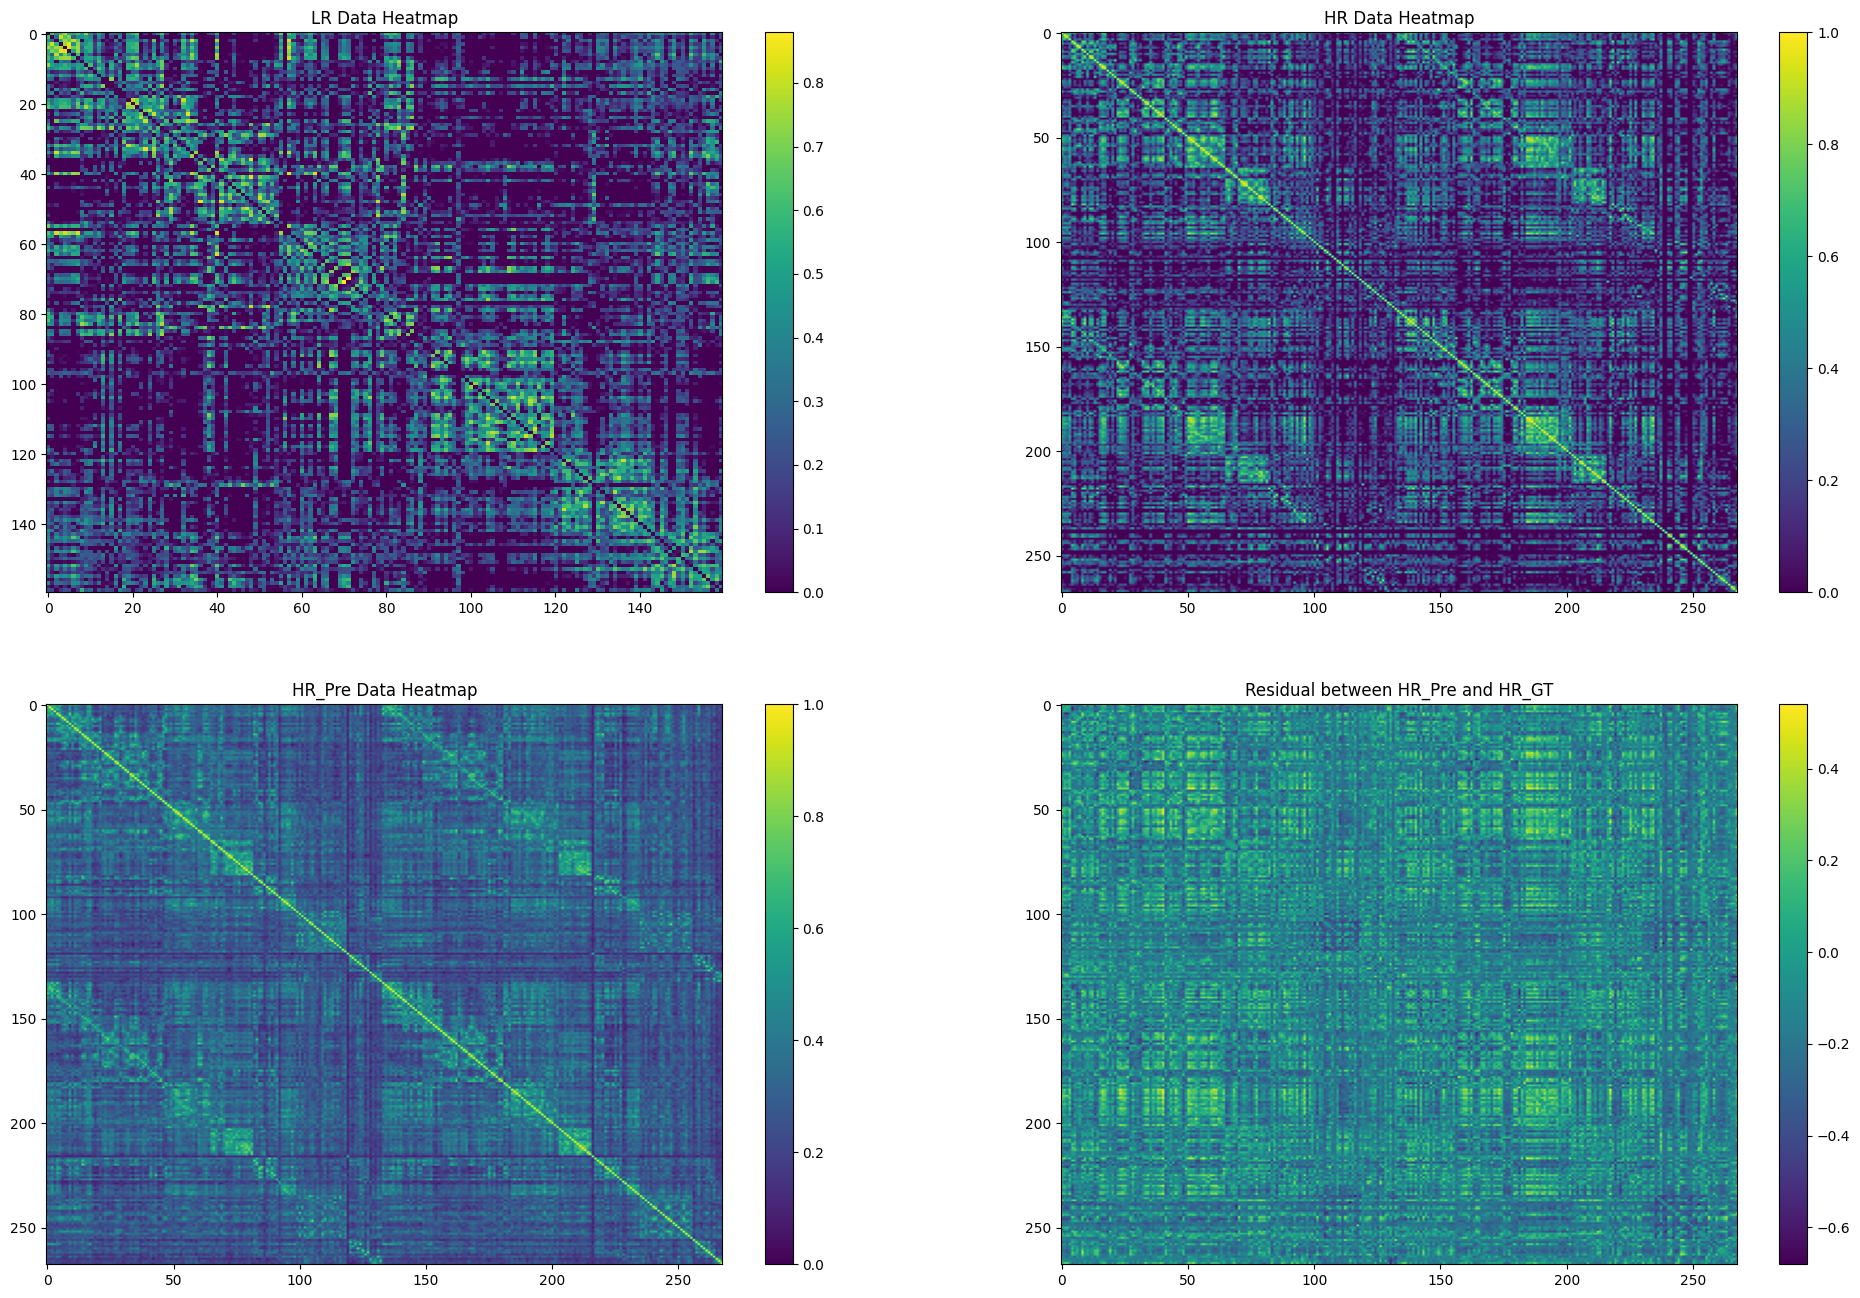

In [19]:
lr_test_array, hr_test_array
lr = lr_test_array[0, :]
hr = hr_test_array[0, :]
lr = torch.from_numpy(lr).type(torch.FloatTensor)
np.fill_diagonal(hr, 1)

preds, a, b, c = model(lr)

plt.figure(figsize=(24, 16))
 
# Heatmap of a subset of LR data
plt.subplot(2,2,1)
plt.imshow(lr, aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('LR Data Heatmap')
 
# Heatmap of a subset of HR data
plt.subplot(2,2,2)
plt.imshow(hr, aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('HR Data Heatmap')
 
# Heatmap of a subset of HR data
plt.subplot(2,2,3)
plt.imshow(preds.detach().cpu().clone().numpy() , aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('HR_Pre Data Heatmap')

# Heatmap of residual
plt.subplot(2,2,4)
plt.imshow(hr - preds.detach().cpu().clone().numpy() , aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('Residual between HR_Pre and HR_GT')
 
plt.show()

# Prepare Submission

In [20]:
lrt_df = pd.read_csv("/notebooks/lr_test.csv") # change the directory if needed
lrt_matrix_size = get_matrix_size(lrt_df.shape[1])
lrt_graphs = load_data_as_graphs(lrt_df, lrt_matrix_size)


lrt_array = np.random.normal(0.5, 1,(len(lrt_graphs), 160, 160))
i = 0
for lrt in lrt_graphs:
    lrt_array[i] = lrt.adjacency_matrix
    i +=1

print(lrt_array.shape)

(112, 160, 160)


In [22]:
def submission(model, data_array, filepath, vector_dim=35778):
    n_samples = data_array.shape[0]

    results_array = np.zeros((n_samples, vector_dim))
    results_array.shape

    # Iterate through each sample in the dataset
    i = 0
    for lr in data_array:
        lr_tensor = torch.from_numpy(lr).type(torch.FloatTensor)

        with torch.no_grad():  
            preds, _, _, _ = model(lr_tensor)

        prediction = preds.detach().cpu().numpy()
        vectorized_pred = MatrixVectorizer.vectorize(prediction) # Vectorize the prediction matrix to a flat array

        results_array[i, :] = vectorized_pred # Store the vectorized prediction in the results array
        i += 1

    print(results_array.shape)
    
    melted_result = results_array.flatten()
    ids = np.arange(1, melted_result.shape[0]+1)
    print(ids.shape)
    print(melted_result.shape)
    df = pd.DataFrame({
        "ID": ids,
        "Predicted": melted_result
    })

    print(df.shape)
    print(df.head())
    df.to_csv(filepath,index=False)
    print("the results are saved")
    return 


In [23]:

submission_filepath = "/notebooks/submission.csv" # change directory if needed
submission(model, lrt_array, submission_filepath)

(112, 35778)
(4007136,)
(4007136,)
(4007136, 2)
   ID  Predicted
0   1   0.533940
1   2   0.587722
2   3   0.646846
3   4   0.595999
4   5   0.656019
the results are saved
